# Modeling

## Load Data

In [1]:
fh = 24 # forecast horizon, predice el consumo dentro de fh horas

import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('../src')

from modeling.baseline import LagNaive, RollingMeanNaive #, MovingAverageNaive
from modeling.traditional_ml import train_random_forest, train_xgboost, train_lightgbm, plot_learning_curve
from utils.metrics import calculate_metrics, print_metrics
results = []

# Cargar splits
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / f'train_{fh}hr.csv', index_col='Datetime', parse_dates=True)
val_df = pd.read_csv(data_dir / f'val_{fh}hr.csv', index_col='Datetime', parse_dates=True)
test_df = pd.read_csv(data_dir / f'test_{fh}hr.csv', index_col='Datetime', parse_dates=True)

# Separar X e y
TARGET_COL = 'PJME_MW'
feature_cols = [col for col in train_df.columns if col != TARGET_COL]

X_train, y_train = train_df[feature_cols], train_df[TARGET_COL]
X_val, y_val = val_df[feature_cols], val_df[TARGET_COL]
X_test, y_test = test_df[feature_cols], test_df[TARGET_COL]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}\n")

train_df.info()
# train_df.describe()
# train_df['PJME_MW'].describe()

X_train shape: (101621, 49)
X_val shape: (21751, 49)
X_test shape: (21753, 49)

<class 'pandas.DataFrame'>
DatetimeIndex: 101621 entries, 2002-01-08 02:00:00 to 2013-08-13 06:00:00
Data columns (total 50 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   PJME_MW                 101621 non-null  float64
 1   hour                    101621 non-null  int64  
 2   dayofweek               101621 non-null  int64  
 3   quarter                 101621 non-null  int64  
 4   month                   101621 non-null  int64  
 5   year                    101621 non-null  int64  
 6   dayofyear               101621 non-null  int64  
 7   weekofyear              101621 non-null  int64  
 8   is_weekend              101621 non-null  int64  
 9   is_month_start          101621 non-null  int64  
 10  is_month_end            101621 non-null  int64  
 11  hour_sin                101621 non-null  float64
 12  hour_cos                1

## Baseline Models

In [2]:
if fh == 1:
    # Lag Naive last hour
    print('Model: Lag Naive 1 hr') #valor de hace 1 hora
    lag_naive = LagNaive(lag_column='lag_1')
    lag_naive.fit(X_train, y_train)
    val_pred = lag_naive.predict(X_val)
    metrics = calculate_metrics(y_val, val_pred, 'LagNaive_1hr - Validation')
    print_metrics(metrics)
    results.append({'model': 'Lag_Naive_1hr', **metrics})

# Lag Naive last day
print('Model: Lag Naive 1 day') #valor de hace 1 día
lag_naive = LagNaive(lag_column='lag_24')
lag_naive.fit(X_train, y_train)
val_pred = lag_naive.predict(X_val)
metrics = calculate_metrics(y_val, val_pred, 'LagNaive_1day - Validation')
print_metrics(metrics)
results.append({'model': 'Lag_Naive_1day', **metrics})

# Lag Naive last week
print('Model: Lag Naive 1 week') #valor de hace 1 semana
lag_naive = LagNaive(lag_column='lag_168')
lag_naive.fit(X_train, y_train)
val_pred = lag_naive.predict(X_val)
metrics = calculate_metrics(y_val, val_pred, 'LagNaive_1week - Validation')
print_metrics(metrics)
results.append({'model': 'Lag_Naive_1week', **metrics})


# Rolling Mean 24h
print("\nModel: Rolling Mean 24h")
rm24 = RollingMeanNaive("rolling_mean_24")
rm24.fit(X_train, y_train)

val_pred_24 = rm24.predict(X_val)
metrics_24 = calculate_metrics(y_val, val_pred_24, "RollingMean_24 - Validation")
print_metrics(metrics_24)

results.append({'model': 'RollingMean_24', **metrics_24})

# Rolling Mean 168h
print("\nModel: Rolling Mean 168h")
rm168 = RollingMeanNaive("rolling_mean_168")
rm168.fit(X_train, y_train)

val_pred_168 = rm168.predict(X_val)
metrics_168 = calculate_metrics(y_val, val_pred_168, "RollingMean_168 - Validation")
print_metrics(metrics_168)

results.append({'model': 'RollingMean_168', **metrics_168})

Model: Lag Naive 1 day

Métricas - LagNaive_1day - Validation
MAE:  3,428.85 MW
RMSE: 4,497.74 MW
MAPE: 10.77%
R²:   0.4711

Model: Lag Naive 1 week

Métricas - LagNaive_1week - Validation
MAE:  3,611.15 MW
RMSE: 4,762.69 MW
MAPE: 11.25%
R²:   0.4069


Model: Rolling Mean 24h

Métricas - RollingMean_24 - Validation
MAE:  4,255.71 MW
RMSE: 5,397.02 MW
MAPE: 13.92%
R²:   0.2384


Model: Rolling Mean 168h

Métricas - RollingMean_168 - Validation
MAE:  4,247.14 MW
RMSE: 5,374.14 MW
MAPE: 13.94%
R²:   0.2449



## Traditional ML Models


 Model: Random Forest
Entrenando Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


Modelo guardado en: ../models/random_forest_24hr.pkl

Métricas - Random Forest - Validation
MAE:  2,086.79 MW
RMSE: 2,782.56 MW
MAPE: 6.52%
R²:   0.7976


 Model: XGBoost
Entrenando XGBoost...
[0]	validation_0-rmse:6235.75287	validation_1-rmse:6010.04586
[60]	validation_0-rmse:1956.04782	validation_1-rmse:2710.60689
[120]	validation_0-rmse:1558.38147	validation_1-rmse:2629.75868
[148]	validation_0-rmse:1438.65336	validation_1-rmse:2659.12694
Modelo guardado en: ../models/xgboost_24hr.pkl

Métricas - XGBoost - Validation
MAE:  1,982.46 MW
RMSE: 2,623.06 MW
MAPE: 6.24%
R²:   0.8201



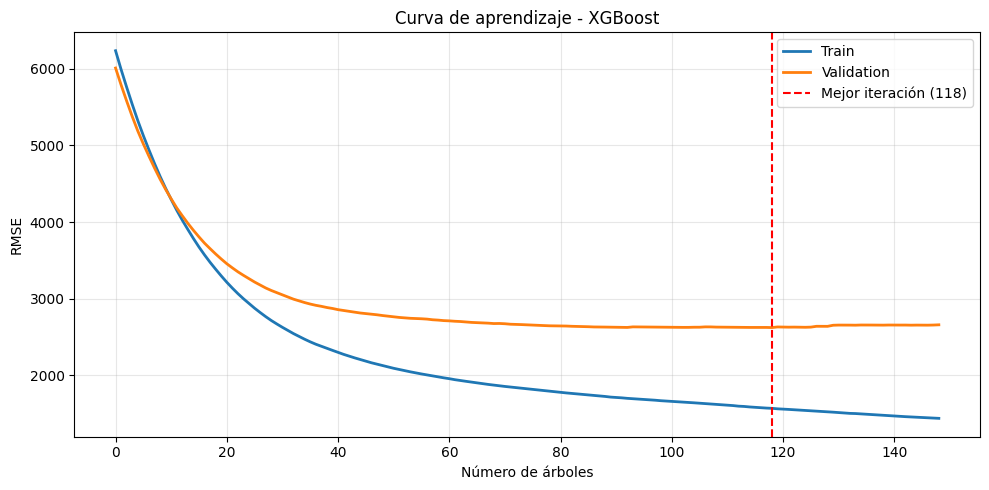


 Model: LightGBM
Entrenando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8360
[LightGBM] [Info] Number of data points in the train set: 101621, number of used features: 49
[LightGBM] [Info] Start training from score 32414.148788
Training until validation scores don't improve for 30 rounds
[60]	training's l2: 6.40868e+06	valid_1's l2: 8.53332e+06
[120]	training's l2: 4.63009e+06	valid_1's l2: 7.7577e+06
Early stopping, best iteration is:
[99]	training's l2: 5.05527e+06	valid_1's l2: 7.56675e+06
Modelo guardado en: ../models/lightgbm_24hr.pkl

Métricas - LightGBM - Validation
MAE:  2,094.49 MW
RMSE: 2,750.77 MW
MAPE: 6.63%
R²:   0.8022



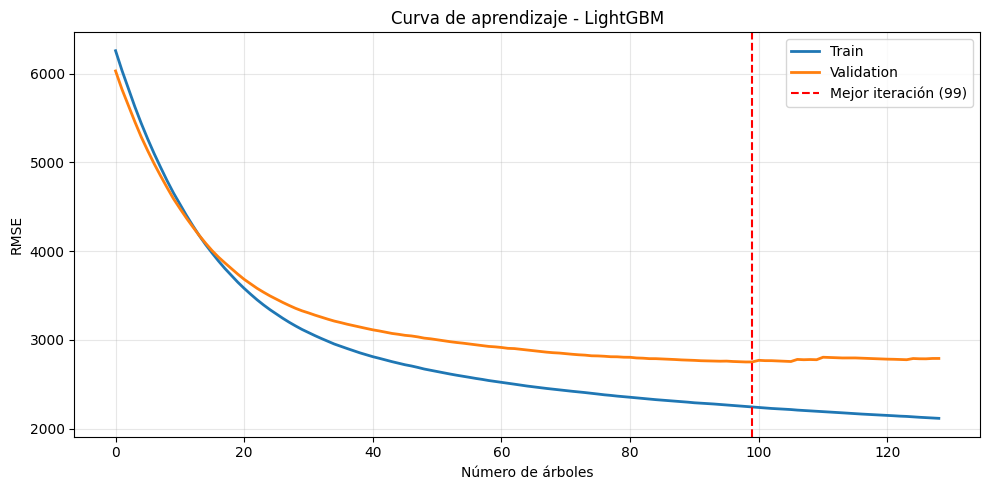

In [3]:
# Random Forest
print('\n Model: Random Forest')
rf, rf_train_pred , rf_val_pred = train_random_forest(
    X_train, y_train, X_val, y_val,
    save_path=f'../models/random_forest_{fh}hr.pkl'
)
metrics_rf = calculate_metrics(y_val, rf_val_pred, 'Random Forest - Validation')
print_metrics(metrics_rf)
results.append({'model': 'Random_Forest', **metrics_rf})

# XGBoost
print('\n Model: XGBoost')
xgb, xgb_train_pred, xgb_val_pred = train_xgboost(
    X_train, y_train, X_val, y_val,
    save_path=f'../models/xgboost_{fh}hr.pkl'
)

metrics_xgb = calculate_metrics(y_val, xgb_val_pred, 'XGBoost - Validation')
print_metrics(metrics_xgb)
results.append({'model': 'XGBoost', **metrics_xgb})
plot_learning_curve(xgb, model_name='XGBoost')

# LightGBM
print('\n Model: LightGBM')
lgbm, lgbm_train_pred, lgbm_val_pred = train_lightgbm(
    X_train, y_train, X_val, y_val,
    save_path=f'../models/lightgbm_{fh}hr.pkl'
)
metrics_lgbm = calculate_metrics(y_val, lgbm_val_pred, "LightGBM - Validation")
print_metrics(metrics_lgbm)
results.append({'model': 'LightGBM', **metrics_lgbm})
plot_learning_curve(lgbm, model_name='LightGBM')

In [4]:
# =====================
# Model Comparison
# =====================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')
print("\n" + "="*70)
print(" Ranking de Modelos (ordenado por RMSE)")
print("="*70)
print(results_df[['model', 'MAE', 'RMSE', 'MAPE', 'R2']].to_string(index=False))

# Guardar resultados
results_df.to_csv(f'../results/model_comparison_{fh}hr.csv', index=False)
print(f"\n Resultados guardados en: ../results/model_comparison_{fh}hr.csv")


 Ranking de Modelos (ordenado por RMSE)
          model         MAE        RMSE      MAPE       R2
        XGBoost 1982.463809 2623.059309  6.237456 0.820102
       LightGBM 2094.491205 2750.772766  6.633388 0.802158
  Random_Forest 2086.791406 2782.557624  6.519467 0.797559
 Lag_Naive_1day 3428.848375 4497.742060 10.773532 0.471070
Lag_Naive_1week 3611.145005 4762.693791 11.254819 0.406918
RollingMean_168 4247.139376 5374.140118 13.935444 0.244860
 RollingMean_24 4255.706067 5397.021642 13.924646 0.238416

 Resultados guardados en: ../results/model_comparison_24hr.csv


In [14]:
xgb_test_pred = xgb.predict(X_test)
metrics_xgb_test = calculate_metrics(y_test, xgb_test_pred, 'XGBoost - Test')
print_metrics(metrics_xgb_test)

lgbm_test_pred = lgbm.predict(X_test)
metrics_lgbm_test = calculate_metrics(y_test, lgbm_test_pred, 'lgbm - Test')
print_metrics(metrics_lgbm_test)


Métricas - XGBoost - Test
MAE:  2,218.07 MW
RMSE: 2,885.88 MW
MAPE: 7.12%
R²:   0.7996


Métricas - lgbm - Test
MAE:  2,297.26 MW
RMSE: 2,982.21 MW
MAPE: 7.39%
R²:   0.7860



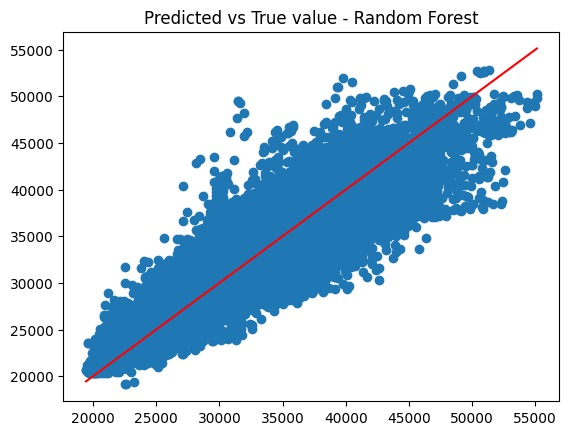

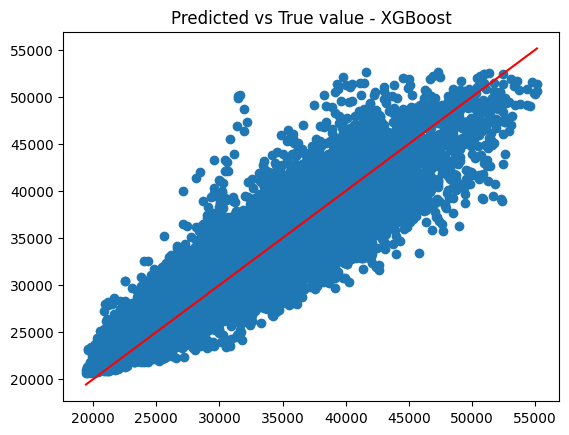

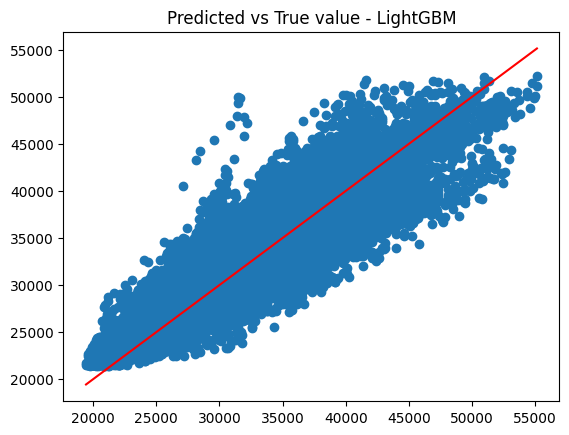

In [5]:
import matplotlib.pyplot as plt
plt.scatter(y_val, rf_val_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r')
plt.title('Predicted vs True value - Random Forest')
plt.show()

plt.scatter(y_val, xgb_val_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r')
plt.title('Predicted vs True value - XGBoost')
plt.show()

plt.scatter(y_val, lgbm_val_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r')
plt.title('Predicted vs True value - LightGBM')
plt.show()

In [6]:
# Feature importance de Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15))

# ¿lag_1 domina todo?
if fh==1:
    lag1_importance = feature_importance[feature_importance['feature'] == 'lag_1']['importance'].values[0]
    print(f"\nImportancia de lag_1: {lag1_importance:.1%}")
    print(f"Importancia del resto: {1-lag1_importance:.1%}")


                  feature  importance
18                 lag_24    0.518619
0                    hour    0.096636
15          dayofweek_cos    0.054186
23                lag_168    0.052272
44  volatility_changes_24    0.023676
28         rolling_max_24    0.020921
14          dayofweek_sin    0.018391
1               dayofweek    0.017169
27         rolling_min_24    0.014026
41    volatility_range_24    0.013875
43              change_1h    0.013398
21                 lag_47    0.010676
32        rolling_max_168    0.010177
5               dayofyear    0.010060
29       rolling_mean_168    0.009450


In [ ]:
# # XGBoost - tres tipos disponibles
# xgb.get_booster().get_score(importance_type='weight')   # frecuencia (default)
# xgb.get_booster().get_score(importance_type='gain')     # reducción promedio de impureza ← más informativo
# xgb.get_booster().get_score(importance_type='cover')    # cantidad de muestras afectadas

# # LightGBM - dos tipos disponibles
# lgbm.booster_.feature_importance(importance_type='split')  # frecuencia (default)
# lgbm.booster_.feature_importance(importance_type='gain')   # reducción de impureza ← más informativo

In [10]:
metric_type = 'gain'  # opciones: 'gain', 'weight', 'cover'

# Feature importance - XGBoost
xgb_gain_scores = xgb.get_booster().get_score(importance_type=metric_type)
feature_importance_xgb_gain = pd.DataFrame({
    'feature': list(xgb_gain_scores.keys()),
    metric_type: list(xgb_gain_scores.values())
}).sort_values(metric_type, ascending=False).reset_index(drop=True)

feature_importance_xgb_gain[f'{metric_type}_pct'] = (
    feature_importance_xgb_gain[metric_type] / feature_importance_xgb_gain[metric_type].sum() * 100
).round(2)

print("="*50)
print(f"XGBoost - Feature Importance ({metric_type})")
print("="*50)
print(feature_importance_xgb_gain.head(15).to_string(index=True))


XGBoost - Feature Importance (gain)
                  feature          gain  gain_pct
0                  lag_24  1.832476e+10     38.71
1                 lag_168  7.652226e+09     16.16
2           dayofweek_cos  3.009641e+09      6.36
3                    hour  2.009501e+09      4.24
4                  lag_25  1.619978e+09      3.42
5          rolling_max_24  1.183302e+09      2.50
6               dayofweek  1.103681e+09      2.33
7                hour_sin  9.949421e+08      2.10
8                  lag_48  9.747032e+08      2.06
9           dayofweek_sin  7.588497e+08      1.60
10    volatility_range_24  7.532963e+08      1.59
11                 lag_47  6.352703e+08      1.34
12               hour_cos  5.691448e+08      1.20
13  volatility_changes_24  5.621889e+08      1.19
14         rolling_min_24  5.172485e+08      1.09


In [11]:

metric_type = 'gain'  # opciones: 'gain', 'weight', 'cover'
# Feature importance - LightGBM
feature_importance_lgbm_gain = pd.DataFrame({
    'feature': X_train.columns,
    metric_type: lgbm.booster_.feature_importance(importance_type=metric_type)
}).sort_values(metric_type, ascending=False).reset_index(drop=True)

feature_importance_lgbm_gain[f'{metric_type}_pct'] = (
    feature_importance_lgbm_gain[metric_type] / feature_importance_lgbm_gain[metric_type].sum() * 100
).round(2)

print("\n" + "="*50)
print(f"LightGBM - Feature Importance ({metric_type})")
print("="*50)
print(feature_importance_lgbm_gain.head(15).to_string(index=True))


LightGBM - Feature Importance (gain)
                  feature          gain  gain_pct
0                  lag_24  1.648707e+13     42.52
1                 lag_168  7.293433e+12     18.81
2                    hour  3.323798e+12      8.57
3           dayofweek_cos  2.123500e+12      5.48
4          rolling_max_24  1.900028e+12      4.90
5               dayofweek  1.052691e+12      2.71
6   volatility_changes_24  7.035512e+11      1.81
7               change_1h  5.402009e+11      1.39
8                hour_sin  5.179324e+11      1.34
9           dayofweek_sin  5.056994e+11      1.30
10         rolling_min_24  4.689667e+11      1.21
11              month_cos  3.695295e+11      0.95
12                 lag_48  3.687175e+11      0.95
13    volatility_range_24  3.488236e+11      0.90
14        rolling_max_168  3.265990e+11      0.84


In [12]:
comparison = pd.DataFrame({
    'feature': feature_importance_xgb_gain['feature'],
    'xgb_gain_pct': feature_importance_xgb_gain['gain_pct']
}).merge(
    feature_importance_lgbm_gain[['feature', 'gain_pct']].rename(columns={'gain_pct': 'lgbm_gain_pct'}),
    on='feature', how='outer'
).merge(
    feature_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    on='feature', how='outer'
).fillna(0).sort_values('xgb_gain_pct', ascending=False).reset_index(drop=True)

print("\n" + "="*65)
print("Comparación Feature Importance - XGB vs LGBM vs RF")
print("="*65)
print(comparison.to_string(index=True))


Comparación Feature Importance - XGB vs LGBM vs RF
                   feature  xgb_gain_pct  lgbm_gain_pct  rf_importance
0                   lag_24         38.71          42.52       0.518619
1                  lag_168         16.16          18.81       0.052272
2            dayofweek_cos          6.36           5.48       0.054186
3                     hour          4.24           8.57       0.096636
4                   lag_25          3.42           0.43       0.008782
5           rolling_max_24          2.50           4.90       0.020921
6                dayofweek          2.33           2.71       0.017169
7                 hour_sin          2.10           1.34       0.006312
8                   lag_48          2.06           0.95       0.006993
9            dayofweek_sin          1.60           1.30       0.018391
10     volatility_range_24          1.59           0.90       0.013875
11                  lag_47          1.34           0.51       0.010676
12                hour_co